In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from fast_hdbscan.numba_kdtree import NumbaKDTree, kdtree_to_numba, rdist, point_to_node_lower_bound_rdist
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
import umap

In [3]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'

In [3]:
%%time

### read all morphotopes
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

data = []
for region_id, _ in region_hulls.iterrows():
    region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
    data.append(region_morphotope_data)

data = pd.concat(data)

CPU times: user 19.4 s, sys: 6.26 s, total: 25.6 s
Wall time: 11.6 s


In [4]:
data.shape

(1046973, 361)

In [5]:
# ## read a single region


# # model_params = '_100_3__median_gaussian_False'

# region_id = 69333
# data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
# data.index = str(region_id) + '_' + data.index

In [6]:
### drop noise
data = data[data.index.str[-2:] != '-1']

In [7]:
# data = data.drop(columns=['mibLAL', 'mibCCo'], level=0)

In [8]:
sizes = data.iloc[:, -1]
data = data.iloc[:, :-1]

In [9]:
vals = StandardScaler().fit_transform(data)
component_data = pd.DataFrame(vals, columns=data.columns, index=data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)


In [10]:
standardised_data = component_data.copy()

In [11]:
sizes.sort_values(ascending=False).describe().iloc[1:]

mean    177.034517
std      72.748388
min     100.000000
25%     122.000000
50%     156.000000
75%     211.000000
max     903.000000
Name: (Size, Size), dtype: float64

In [12]:
component_data = standardised_data.drop(columns=['percentile_25', 'percentile_75', 'median', 'std'], level=1)

In [13]:
component_data.columns.get_level_values(0).unique()

Index(['sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI',
       'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'mtbSWR', 'libNCo', 'ldbPWL',
       'ltcBuA', 'mtbAli', 'mtbNDi', 'ltbIBD', 'stbCeA', 'stbSAl', 'sdsLen',
       'sssLin', 'ldsMSL', 'ldsRea', 'ldsAre', 'sisBpM', 'sdsSPW', 'sdsSPO',
       'sdsSWD', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W', 'linPDE', 'lcnClo',
       'lddNDe', 'linWID', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'sddAre', 'midRea',
       'midAre', 'stcOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'mtcWNe',
       'mdcAre', 'ltcWRB', 'sicCAR', 'stcSAl', 'ldkAre', 'ldkPer', 'lskCCo',
       'lskERI', 'lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'sdsAre', 'likWCe',
       'mibCou', 'mibAre', 'mibLen', 'mibElo', 'mibERI', 'mibCCo', 'mibLAL',
       'mibFR', 'mibSCo'],
      dtype='object')

In [14]:
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
# 'sdbAre', 'ssbCCM', 'sdcLAL'
    # 'mibCCo', 'mibLAL'
]

In [15]:
component_data = component_data.drop(
    columns=to_drop, level=0)

In [16]:
component_data.columns =  ['_'.join(col).strip() for col in component_data.columns.values]

In [17]:
%%time
desc = component_data.describe()

CPU times: user 409 ms, sys: 9.16 ms, total: 418 ms
Wall time: 417 ms


In [18]:
(desc.loc['max'] - desc.loc['min']).sort_values()

sdsSPO_mean      5.055496
ltcBuA_mean      6.077051
mtbAli_mean      7.917782
mtbSWR_mean      8.711377
sdsSPW_mean      9.536756
stbSAl_mean      9.919716
sdcLAL_mean      9.993331
mtbNDi_mean     10.591417
mibERI_mean     10.967000
linWID_mean     10.996505
mibElo_mean     11.324640
sicCAR_mean     11.364033
sssLin_mean     11.401305
linP3W_mean     11.848099
mtdDeg_mean     12.040789
linPDE_mean     12.193535
sdsSWD_mean     12.651702
linP4W_mean     12.749638
mibCCo_mean     14.156268
mtcWNe_mean     15.450934
ssbElo_mean     16.379309
sdcAre_mean     17.103776
ltcWRB_mean     17.871926
ldsAre_mean     19.118442
ldsRea_mean     19.324691
sscCCo_mean     19.629408
ssbERI_mean     22.466791
ssbCCD_mean     24.590049
xcnSCl_mean     26.719757
midAre_mean     27.234132
ltbIBD_mean     27.444327
lcnClo_mean     29.409613
mdcAre_mean     29.897695
ssbCCo_mean     30.210102
ldsCDL_mean     30.374534
ldsMSL_mean     30.772876
midRea_mean     30.956144
sdsLen_mean     30.958412
ssbCor_mean 

In [19]:
(desc.loc['75%'] - desc.loc['25%']).sort_values()

sdbCoA_mean    0.000000
libNCo_mean    0.000000
mibAre_mean    0.062368
mibLen_mean    0.100476
ldbPWL_mean    0.111551
mibLAL_mean    0.211328
mibCou_mean    0.297826
sdsAre_mean    0.401666
sddAre_mean    0.440355
sdbAre_mean    0.453264
sdsLen_mean    0.497349
ldsCDL_mean    0.516350
midAre_mean    0.548614
mtdMDi_mean    0.561729
sisBpM_mean    0.596350
lcnClo_mean    0.605906
ldsAre_mean    0.627590
mibFR_mean     0.675597
mibSCo_mean    0.675597
sssLin_mean    0.720413
mibERI_mean    0.811583
ssbCCD_mean    0.833316
sdbPer_mean    0.849867
ldsMSL_mean    0.855795
midRea_mean    0.891262
mtdDeg_mean    0.913696
ssbCCM_mean    0.929008
ssbSqu_mean    0.950954
ssbCor_mean    0.953448
ldsRea_mean    1.016581
sdcAre_mean    1.029509
ssbERI_mean    1.031175
lddNDe_mean    1.032259
mdcAre_mean    1.040967
mibCCo_mean    1.048587
mibElo_mean    1.060166
sscCCo_mean    1.091310
xcnSCl_mean    1.144343
ltbIBD_mean    1.148488
ssbCCo_mean    1.165607
sicCAR_mean    1.167245
mtbNDi_mean    1

In [17]:
x = component_data.loc['69333_849_236'] # karlin offices
y = component_data.loc['69333_849_182'] # zelena liska
z = component_data.loc['69333_849_486'] # chodov

np.sqrt(((x - y)**2).sum()), np.sqrt(((y - z)**2).sum())

(np.float64(8.84110958854128), np.float64(9.913293362707826))

In [18]:
(x-y).iloc[(x - y).abs().argsort().values[::-1]].iloc[:25]

sdbCoA_mean    4.022492
sdcAre_mean    3.984369
ssbCor_mean    3.640017
mdcAre_mean    2.645649
sdcLAL_mean    1.792943
sdbAre_mean    1.690348
mtbNDi_mean    1.521084
ssbCCM_mean    1.482951
ssbERI_mean   -1.385401
linPDE_mean    1.247006
mtdDeg_mean   -1.203678
ssbCCD_mean    1.075466
mibElo_mean    1.054611
linP3W_mean   -0.899570
sdbPer_mean    0.887113
ssbElo_mean    0.859899
mibCCo_mean    0.837118
sscERI_mean   -0.773786
sicCAR_mean   -0.736595
sscCCo_mean    0.624066
mibSCo_mean   -0.615479
mibFR_mean    -0.615479
lcdMes_mean   -0.612787
mtbSWR_mean   -0.579919
ssbCCo_mean    0.529240
dtype: float64

In [19]:
(y - z).iloc[(y - z).abs().argsort().values[::-1]].iloc[:25]

sdbCoA_mean    7.412880
ssbSqu_mean    2.069991
lcdMes_mean    1.998629
sscCCo_mean   -1.836046
linPDE_mean   -1.821915
mdcAre_mean   -1.720401
mtbAli_mean    1.668633
ssbERI_mean    1.611204
sssLin_mean    1.486647
linP3W_mean    1.422661
ssbCCM_mean    1.325559
sscERI_mean   -1.137118
mibCCo_mean   -1.120127
ssbCor_mean    1.044433
ltcBuA_mean   -1.014777
mibElo_mean   -0.955507
mtbSWR_mean    0.856398
ssbCCo_mean   -0.804218
sdbAre_mean    0.795624
sdcAre_mean   -0.788661
ltbIBD_mean   -0.759279
mibFR_mean     0.702737
mibSCo_mean    0.702737
mibAre_mean    0.627306
sdbPer_mean   -0.603346
dtype: float64

In [20]:
(x - z).iloc[(x - z).abs().argsort().values[::-1]].iloc[:25]

sdbCoA_mean    11.435373
ssbCor_mean     4.684450
sdcAre_mean     3.195708
ssbCCM_mean     2.808510
sdbAre_mean     2.485971
sscERI_mean    -1.910905
ssbSqu_mean     1.868737
mtbAli_mean     1.846933
sssLin_mean     1.605119
lcdMes_mean     1.385842
sdcLAL_mean     1.305528
sscCCo_mean    -1.211980
mtbNDi_mean     1.130538
mdcAre_mean     0.925248
ssbCCD_mean     0.777969
linWID_mean     0.711534
mtdDeg_mean    -0.706660
ltcBuA_mean    -0.665788
linPDE_mean    -0.574909
linP3W_mean     0.523091
lddNDe_mean     0.488031
ssbElo_mean     0.372072
sdsSWD_mean     0.335930
mibERI_mean    -0.291230
stbSAl_mean    -0.287568
dtype: float64

In [36]:
from sklearn.cluster import AgglomerativeClustering

In [37]:
# %%time
# linkage = 'single'
# metric = 'euclidean'

# from sklearn.cluster import AgglomerativeClustering
# from core.cluster_validation import get_linkage_matrix
# clusterer = AgglomerativeClustering(linkage=linkage,
#                                     metric=metric,
#                                     compute_full_tree=True,
#                                     compute_distances=True)
# model = clusterer.fit(component_data)
# linkage_matrix = get_linkage_matrix(model)

CPU times: user 35min 15s, sys: 14.8 s, total: 35min 29s
Wall time: 34min 58s


In [20]:
from sklearn.neighbors import KDTree
sklearn_tree = KDTree(component_data)

In [21]:
### 182 and similar to be split
### 69333_849_104 and _12 and their similar to be kept - vinohrady and josefof
### 69333_849_235 - karlin/centre stuff
### 135 - urban
## 69333_849_12, 69333_849_5, 69333_849_103	 - mala strana
## 445 strizkov, goign to industrial areas
# 205 - cerny most, also looks weird?

In [22]:
dists, indxs = sklearn_tree.query(component_data.loc[['69333_849_205']], k=30)

In [23]:
component_data.iloc[indxs[0]]

,sdbAre_mean,sdbPer_mean,sdbCoA_mean,ssbCCo_mean,ssbCor_mean,ssbSqu_mean,ssbERI_mean,ssbElo_mean,ssbCCM_mean,ssbCCD_mean,...,sdsAre_mean,mibCou_mean,mibAre_mean,mibLen_mean,mibElo_mean,mibERI_mean,mibCCo_mean,mibLAL_mean,mibFR_mean,mibSCo_mean
69333_849_205,5.473493,7.158442,0.060902,-2.636543,3.150329,1.451710,-3.693732,-1.555467,3.957053,7.836945,...,-0.258790,-0.202677,0.202171,0.211299,-1.540979,-0.320780,-1.302819,0.618793,2.515948,2.515948
69333_849_407,5.479133,7.307659,0.633278,-4.069985,3.704235,1.341001,-4.679939,-2.517246,4.325452,7.794243,...,-0.231941,-0.328514,0.166906,0.174967,-1.645573,-0.257534,-1.347232,0.514602,2.351919,2.351919
69333_849_500,5.094342,6.398702,-0.077568,-3.869269,1.907304,0.963641,-2.642896,-2.900423,4.310943,6.287426,...,-0.266577,-0.326830,0.148440,0.117178,-1.855605,0.162771,-1.216309,0.441330,2.577286,2.577286
69333_849_494,5.240356,6.533155,-0.077568,-3.863560,1.809062,1.175439,-2.723415,-2.579468,4.180078,5.715649,...,-0.329460,-0.306909,0.160258,0.160143,-1.938600,-0.051657,-1.552816,0.518454,2.404776,2.404776
69333_849_529,4.611802,5.845784,0.259342,-3.014109,2.526627,0.249436,-2.484935,-2.035853,4.102503,5.841360,...,-0.270688,-0.307781,0.141807,0.132686,-1.680429,0.268377,-0.973896,0.467191,2.207608,2.207608
107131_805_1546,5.512495,5.552455,0.041565,-3.391095,3.924609,1.806352,-2.428042,-2.671003,4.829677,5.526463,...,-0.096212,-0.289117,0.236747,0.158958,-1.285878,-0.049217,-0.809020,0.443057,2.901224,2.901224
69333_849_476,6.490951,7.408454,-0.077568,-2.495384,5.004612,0.548250,-5.495843,-0.545147,4.332381,7.203789,...,-0.290597,-0.419141,0.163071,0.112730,0.047694,-0.153982,-0.184352,0.344506,2.748395,2.748395
69333_849_435,6.972943,6.968267,-0.077568,-1.395422,4.761650,0.840071,-3.720645,-1.063086,4.469021,6.675184,...,-0.294483,-0.359732,0.318281,0.238850,-0.361971,-0.257988,-0.096226,0.524948,3.261317,3.261317
62954_3396_37,5.296473,5.500680,1.127614,-2.850954,4.010513,0.979077,-2.966333,-1.679228,4.531406,5.880923,...,-0.159746,-0.365348,0.145895,0.094317,-1.013203,0.128148,-0.661837,0.323286,1.829296,1.829296
87615_611_37,7.638028,6.636575,-0.077568,-3.315790,2.711338,0.261873,-3.456758,-1.947123,5.331250,8.539929,...,-0.187604,-0.171957,0.430492,0.351083,-1.241287,-0.687598,-1.351950,0.824996,3.113789,3.113789


In [24]:
region_id = 69333


etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['morph'] = "-1"

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]
etcs.loc[morphotopes.index, 'morph'] = morphotopes.values

In [40]:
# etcs[etcs.morph == '849_407'].explore()

In [30]:
from core.generate_clusters import preprocess_clustering_data,get_clusters,get_tree

In [31]:
from libpysal.graph import read_parquet
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}.parquet")
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')


min_cluster_size = 100
clip=None
eom_clusters = False
linkage='ward'
metric='euclidean'

In [32]:
# label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [33]:
def post_process_clusters_tightening(group, min_cluster_size, t=7):
    '''Drop cluster parts that are ``t`` standard deviations away from every part of the morphotope'''
    
    if group.name == -1: return pd.Series(np.full(group.shape[0], -1), group.index)

    clusterer = AgglomerativeClustering(linkage='single',
                                    metric='euclidean',
                                    compute_full_tree=True,
                                    compute_distances=True)
    model = clusterer.fit(group.values)
    linkage_matrix = get_linkage_matrix(model)
    clusters = fcluster(linkage_matrix, t=7, criterion='distance')
    
    chars_clusters = pd.Series(clusters).value_counts()
    chars_clusters[chars_clusters < min_cluster_size] = -1
    chars_clusters[chars_clusters >= min_cluster_size] = group.name
    clusters = pd.Series(clusters).map(lambda x: chars_clusters.loc[x]).values
    return pd.Series(clusters, group.index)

In [34]:
%%time
results = {}

for label, group in labels.groupby(labels):

    if group.shape[0] <= min_cluster_size:
        component_clusters = np.full(group.shape[0], -1)

    else:
        component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values], clip=clip, to_drop=to_drop)
        component_graph = building_graph.subgraph(group.index.values)
        ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)

        # # sometimes ward linkage breaks the monotonic increase in the MST
        # # if that happens shift all distances by the max drop
        # # need a loop because several connections might be problematic
        problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
        while problem_idxs.shape[0]:
            ward_tree[problem_idxs + 1, 2] = ward_tree[problem_idxs, 2] + .01
            problem_idxs = np.where(ward_tree[1:, 2] < ward_tree[0:-1, 2])[0]
        # check if ward tree distances are always increasing
        assert (ward_tree[1:, 2] >= ward_tree[0:-1, 2]).all()
        
        component_clusters = get_clusters(ward_tree, min_cluster_size, component_buildings_data.shape[0], eom_clusters=eom_clusters)
            
       ## post process
        res = component_buildings_data.groupby(component_clusters).apply(post_process_clusters, min_cluster_size=min_cluster_size)
        if res.shape[0] == 1:
            component_clusters = pd.Series(res.values[0], res.columns)
        else:
            component_clusters = pd.Series(res.values, res.index.get_level_values(1)).loc[component_buildings_data.index].values
        
        # for c in np.unique(component_clusters):
        #     # if c == -1: continue
        #     cluster_graph = component_graph.subgraph(group.index[component_clusters == c].values)
        #     assert cluster_graph.n_components == 1
    
    results[label] = component_clusters

### relabel local clusters(0,1,2,0,1) to regional clusters(0_0,0_1,0_2, 0_0,0_1,) etc
label_groups = labels.groupby(labels)
region_cluster_labels = []
for label, component_clusters in results.items():
    group = label_groups.get_group(label)
    component_labels = str(label) + '_' + pd.Series(component_clusters.astype(str), 
                                                    index=group.index.values)
    region_cluster_labels.append(component_labels)

region_cluster_labels = pd.concat(region_cluster_labels).sort_index()
assert (X_train[X_train.index >= 0].index == region_cluster_labels.index).all()

CPU times: user 47.6 s, sys: 152 ms, total: 47.7 s
Wall time: 47.7 s


In [35]:
region_cluster_labels

0            0_-1
1            1_-1
2            1_-1
3            1_-1
4            1_-1
           ...   
447721    849_527
447722    849_509
447723    1355_-1
447724    849_205
447725    849_407
Length: 447726, dtype: object

In [128]:
spatial_lag = 3
kernel='gaussian'
lag_type = '_'
lag_dir = '/data/uscuni-ulce/processed_data/lag/'

In [130]:
lag_data = pd.read_parquet(f'{lag_dir}{region_id}_{kernel}_lag_{spatial_lag}.parquet')

In [132]:
lag_data = lag_data.loc[region_cluster_labels.index]

In [138]:
clustering_data = lag_data.groupby(region_cluster_labels).agg('median')

In [139]:
component_data_index = clustering_data.index
component_data = clustering_data.reset_index(drop=True)

component_data.columns =  ['_'.join(col).strip() for col in component_data.columns.values]
component_data = preprocess_clustering_data(component_data, clip, to_drop)
component_data = component_data.set_index(component_data_index)

In [159]:
%%time

## k-256, mean and std split the big blocks into at least 2 clusters...
from sklearn.cluster import KMeans, MiniBatchKMeans
kmeans_clusterer = KMeans(n_clusters=64, max_iter=500, random_state=123)
kmeans_clusters = kmeans_clusterer.fit(component_data).labels_

CPU times: user 2.35 s, sys: 5.64 ms, total: 2.35 s
Wall time: 123 ms


In [160]:

linkage = 'ward'
metric = 'euclidean'
sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(kmeans_clusterer.cluster_centers_)
linkage_matrix = get_linkage_matrix(model)

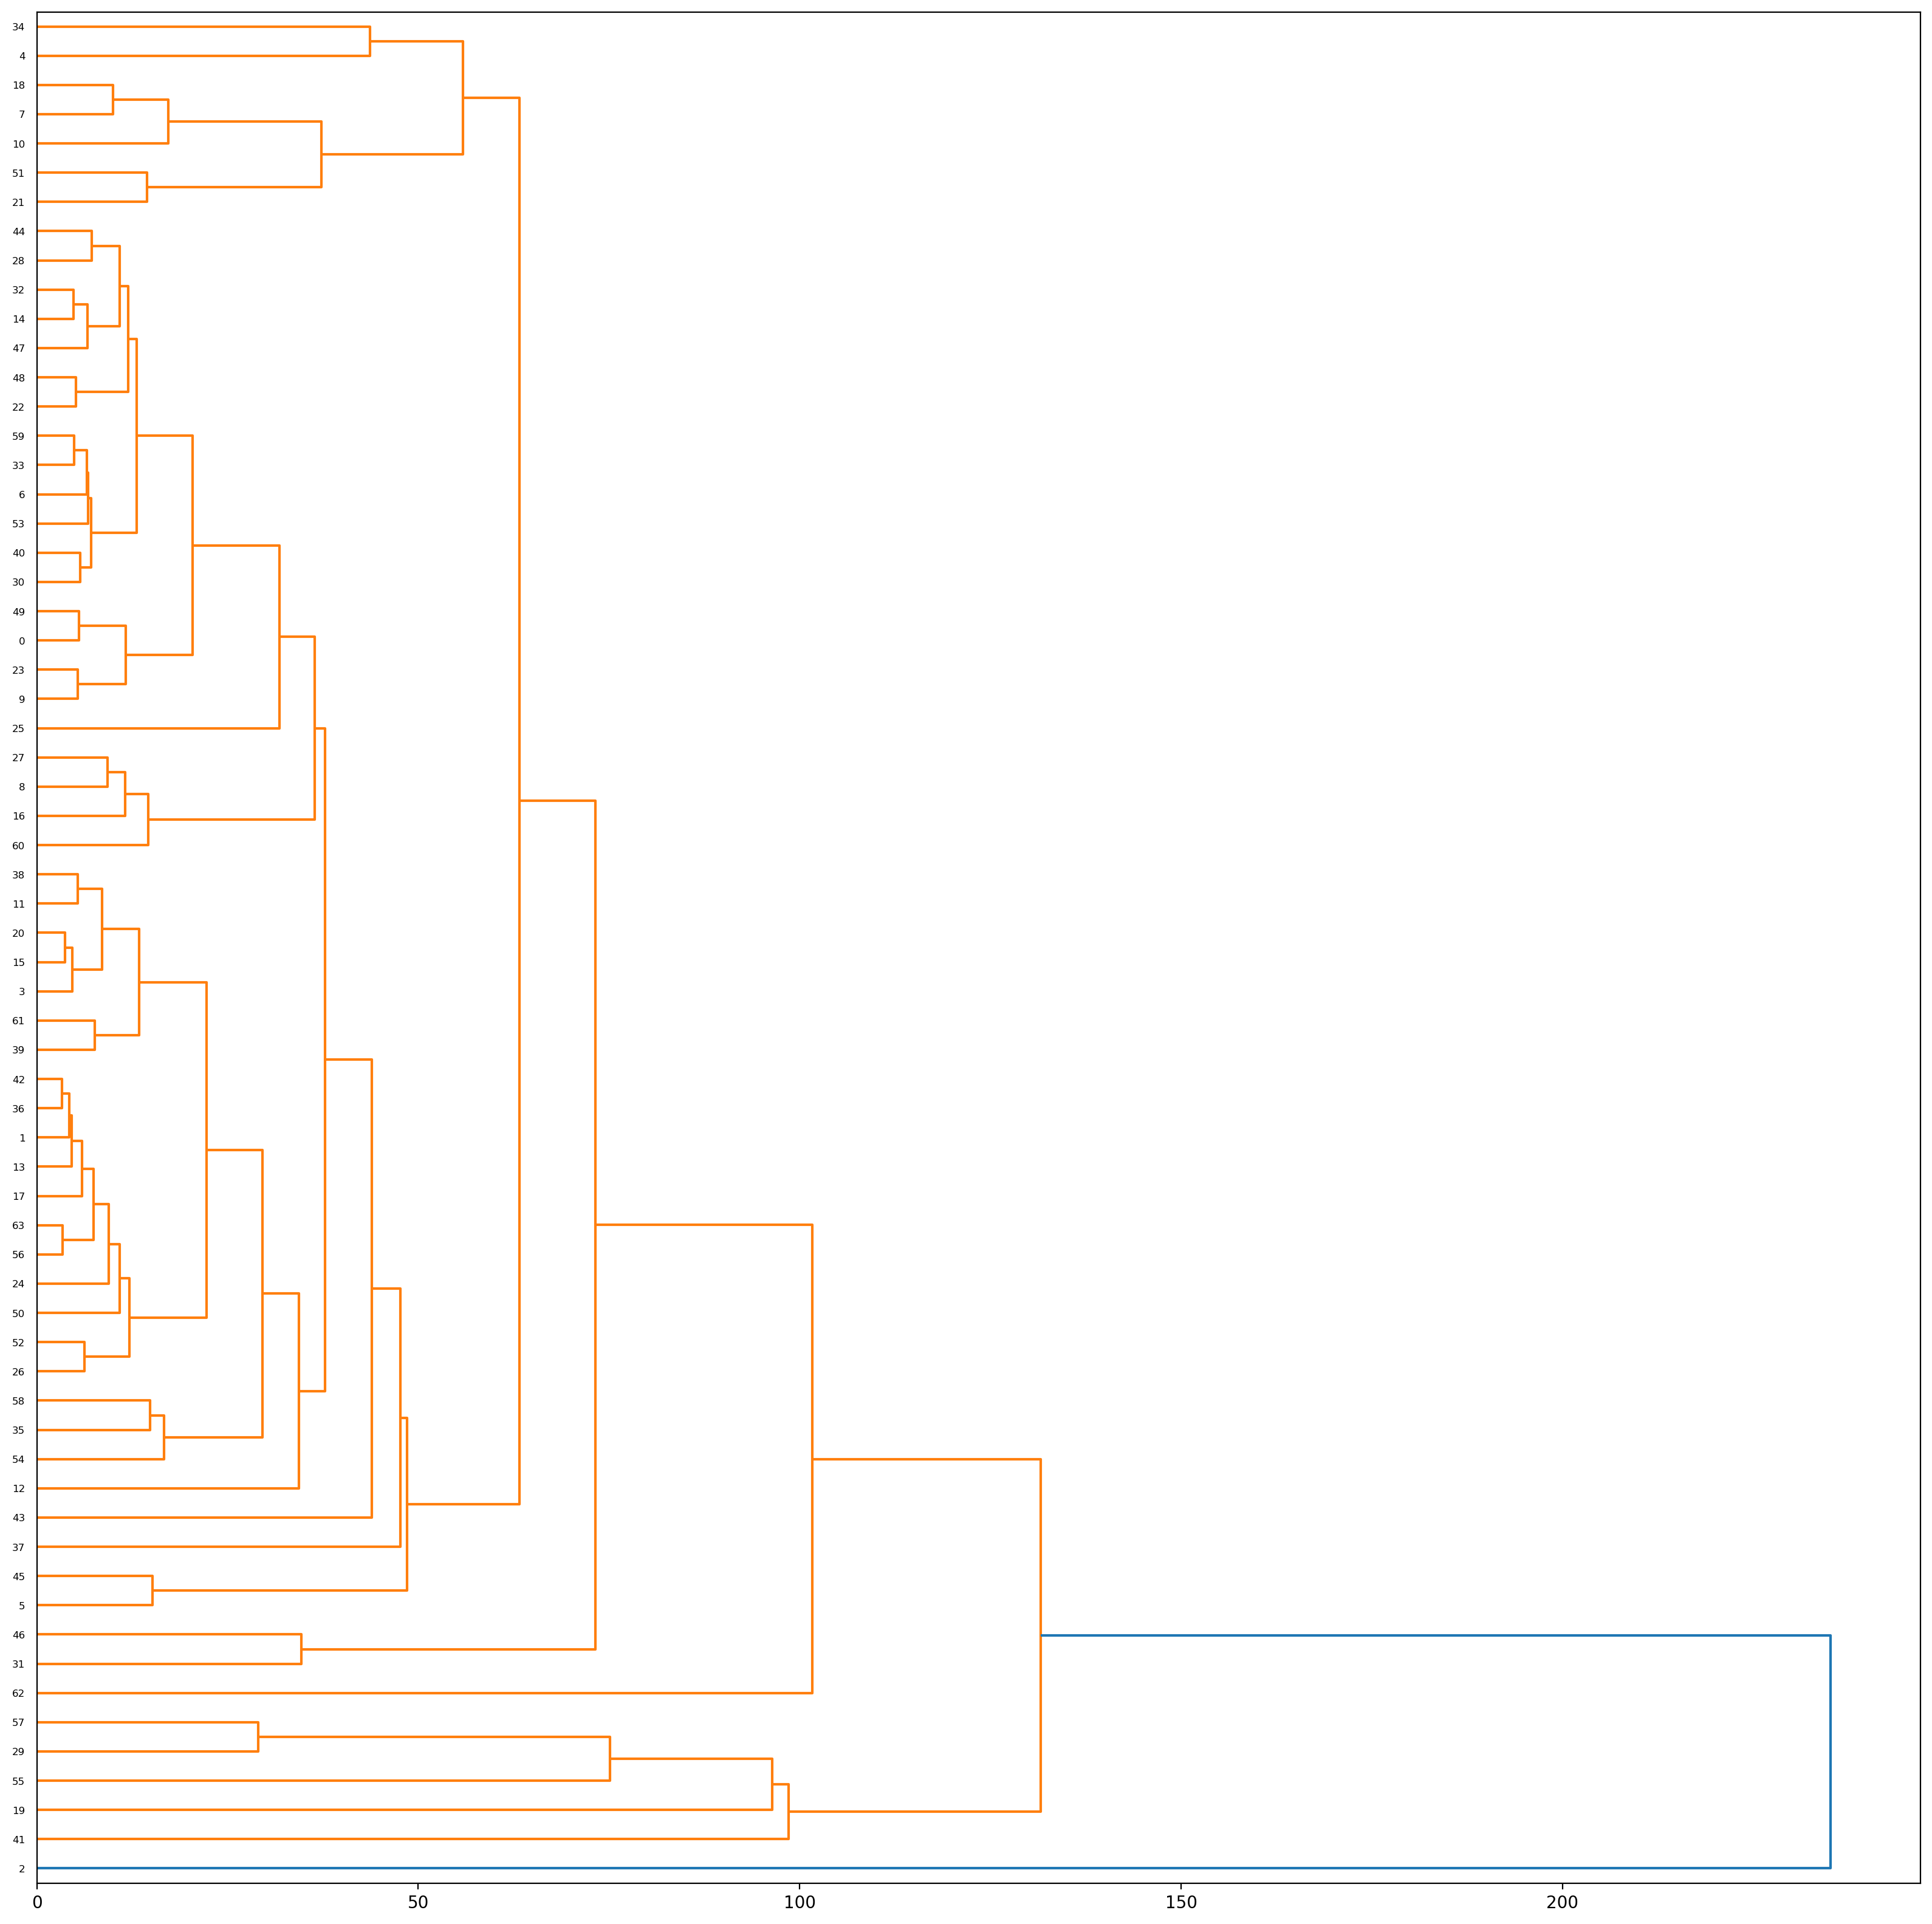

In [161]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, fcluster
from hdbscan.plots import SingleLinkageTree

fig,ax = plt.subplots(figsize=(20,20), dpi=200)
_ = dendrogram(linkage_matrix, ax=ax, orientation='right')

# fig, ax = plt.subplots(figsize=(20,10))
# SingleLinkageTree(linkage_matrix).plot(axis=ax)

In [43]:
pd.Series(linkage_matrix[:, 2]).describe()

count    356331.000000
mean          2.718217
std           1.362448
min           0.868562
25%           2.138306
50%           2.502614
75%           3.031688
max         304.429754
dtype: float64

In [157]:
cutoff = 3
kmeans_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')


In [158]:
# ward_clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
# ward_clusters = pd.Series(ward_clusters, index=np.arange(np.unique(kmeans_clusters).shape[0]))
# np.unique(ward_clusters)

In [159]:
# clusters = pd.Series(kmeans_clusters).map(lambda x: ward_clusters.loc[x]).values

In [160]:
clusters = kmeans_clusters.copy()

In [161]:
region_id = 69333


etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['label'] = -1

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  str(region_id) + '_' + morphotopes.values[:, 0]

region_clusters = pd.Series(clusters, component_data.index)
region_clusters

4_0_0           92395
4_0_1           88162
4_0_10          24024
4_0_11              6
4_0_12              6
                ...  
139096_942_0    89916
139096_98_0     90663
139096_990_0    20552
139096_99_0         6
139096_99_1         6
Length: 356332, dtype: int32

In [162]:
region_clusters.nunique()

92941

In [163]:
region_clusters.value_counts()

6        260019
1158         20
7592         11
3224         11
6980         11
          ...  
71545         1
1609          1
22431         1
23666         1
60838         1
Name: count, Length: 92941, dtype: int64

In [164]:
%%time
## assign morphotope clusters to tess cells

etcs.loc[morphotopes.index, 'label'] = morphotopes.morphotope_label.map(lambda x: region_clusters.loc[x] if x in region_clusters.index else -1).values


CPU times: user 1.08 s, sys: 63.2 ms, total: 1.14 s
Wall time: 1.08 s


In [165]:
# %%time
# # # # relabel morphotopes for plotting
# morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
#                        np.unique(morphotopes.values))
# etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
# etcs['morph'] = '-1'
# etcs.loc[morphotopes.index, 'morph'] = morphotopes.values

In [166]:
etcs.label.value_counts()

label
 6        245374
-1        108131
 71508       692
 40132       669
 59352       632
           ...  
 91943       100
 16989       100
 13914       100
 16304       100
 91944       100
Name: count, Length: 586, dtype: int64

In [167]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

In [88]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 6.9 s, sys: 340 ms, total: 7.24 s
Wall time: 7.24 s


In [89]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [101]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

In [44]:
1

1